# Model

In this section, we grabbed daily data for selected 10 stocks from Jan 1, 2019 to Jan 1, 2020 and ran the portfolio allocation model for different risk ceilings. Because of the high dependenncy among the stocks, we tried to run at vary low risk ceilings with very tiny steop. We also showed the shape of the efficient frontier and how our allocation into different stocks will vary.

## 1. Import the modules

In [24]:
# some useful modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *

## 2. Download Stock Market Data

Based on the previous selection of stocks in EDA, we pulled out the daily data of the 10 stocks from Jan 1, 2019 to Jan 1, 2020.

The 10 stocks are  BKR, CVX, EOG, MPC, OKE, PSX, PXD, VLO, WMB, XOM.



In [25]:
# some stock-specific packages
!pip install yahoo_fin
!pip install requests_html
import yahoo_fin.stock_info as si

In [96]:
# Assign the ticker list that we want to scrap
tickers_list = ['BKR', 'CVX', 'EOG', 'MPC', 'OKE', 'PSX', 'PXD', 'VLO', 'WMB', 'XOM']

# pull historical price data for each stocks 
dow_prices = {ticker : si.get_data(ticker,start_date = '01/01/2019',end_date='01/01/2020',interval='1d') for ticker in tickers_list}

In [27]:
# Each stock has 252 daily entries and 7 variables
dow_prices

{'BKR':                  open       high        low  ...   adjclose   volume  ticker
 2019-01-02  21.190001  21.629999  20.840000  ...  19.783775  7150000     BKR
 2019-01-03  21.090000  21.350000  20.540001  ...  19.652199  6672900     BKR
 2019-01-04  21.340000  22.120001  21.270000  ...  20.639034  5040400     BKR
 2019-01-07  21.940001  22.750000  21.820000  ...  21.193548  4740000     BKR
 2019-01-08  22.830000  23.270000  22.639999  ...  21.813845  4959100     BKR
 ...               ...        ...        ...  ...        ...      ...     ...
 2019-12-24  25.420000  25.740000  25.410000  ...  24.711636   958400     BKR
 2019-12-26  25.709999  25.719999  25.420000  ...  24.789223  2146700     BKR
 2019-12-27  25.660000  25.809999  25.350000  ...  24.721334  2555900     BKR
 2019-12-30  25.570000  25.900000  25.490000  ...  24.857113  2828500     BKR
 2019-12-31  25.400000  25.639999  25.090000  ...  24.857113  3114100     BKR
 
 [252 rows x 7 columns],
 'CVX':                   open

## 3. Create a dataframe showing the price and return of the 10 stocks

3.1 Use the variable 'adjclosed'  as the daily price of the stock.

In [98]:
# get the adjclosed price for the BKR as one example
prep_data = pd.DataFrame(dow_prices['BKR']['adjclose']).rename(columns = {"adjclose":"BKR"})

# combine all the tickers (all the rest of the samples)
for i in tickers_list[1:]:
  prep_data[i] = pd.DataFrame(dow_prices[i]['adjclose'])
prep_data

,BKR,CVX,EOG,MPC,OKE,PSX,PXD,VLO,WMB,XOM
2019-01-02,19.783775,102.145683,86.888954,55.066082,46.321224,81.979561,130.504013,69.277588,19.802347,63.072178
2019-01-03,19.652199,100.189331,86.275230,54.262802,46.210548,80.844589,130.921844,68.030678,19.970163,62.103798
2019-01-04,20.639034,102.265648,90.063004,56.921928,48.228222,84.510025,135.352966,70.607040,20.800415,64.393532
2019-01-07,21.193548,103.594482,90.628784,57.485149,49.071045,85.096130,138.297348,70.680389,21.330360,64.728394
2019-01-08,21.813845,103.142319,91.597298,58.048367,50.118191,85.021690,138.180725,70.927940,21.966297,65.199020
...,...,...,...,...,...,...,...,...,...,...
2019-12-24,24.711636,115.562683,81.317070,58.471191,67.803513,109.101906,148.340134,90.928215,22.349529,66.405968
2019-12-26,24.789223,115.812355,81.161842,57.991684,68.278854,108.003181,148.613754,90.278053,22.321404,66.510292
2019-12-27,24.721334,115.524277,80.667007,57.905373,67.902168,106.596031,148.320587,89.111565,22.115158,66.282677
2019-12-30,24.857113,115.092133,79.939316,57.224472,67.642075,106.374367,147.859985,88.805603,21.749542,65.893845


3.2 Rather than use the raw time series, let's build a model based on past returns (the difference from the previous day).

In [107]:
# create return features for each ticker and use a pct_change as the return
return_data = prep_data.pct_change()
return_data.dropna(inplace=True)
return_data


,BKR,CVX,EOG,MPC,OKE,PSX,PXD,VLO,WMB,XOM
2019-01-03,-0.006651,-0.019153,-0.007063,-0.014588,-0.002389,-0.013845,0.003202,-0.017999,0.008475,-0.015354
2019-01-04,0.050215,0.020724,0.043903,0.049005,0.043663,0.045339,0.033846,0.037871,0.041575,0.036869
2019-01-07,0.026867,0.012994,0.006282,0.009895,0.017476,0.006935,0.021753,0.001039,0.025478,0.005200
2019-01-08,0.029268,-0.004365,0.010687,0.009798,0.021339,-0.000875,-0.000843,0.003502,0.029814,0.007271
2019-01-09,-0.001723,0.013420,0.038421,0.021473,0.014608,0.006565,0.025387,-0.000905,0.011259,0.005275
...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.001176,0.000083,0.005157,0.005110,-0.005132,0.004704,0.005764,-0.001470,-0.004177,-0.003841
2019-12-26,0.003140,0.002160,-0.001909,-0.008201,0.007011,-0.010071,0.001845,-0.007150,-0.001258,0.001571
2019-12-27,-0.002739,-0.002487,-0.006097,-0.001488,-0.005517,-0.013029,-0.001973,-0.012921,-0.009240,-0.003422
2019-12-30,0.005492,-0.003741,-0.009021,-0.011759,-0.003830,-0.002079,-0.003105,-0.003433,-0.016532,-0.005866


## 4. Visualize the 10 stocks 

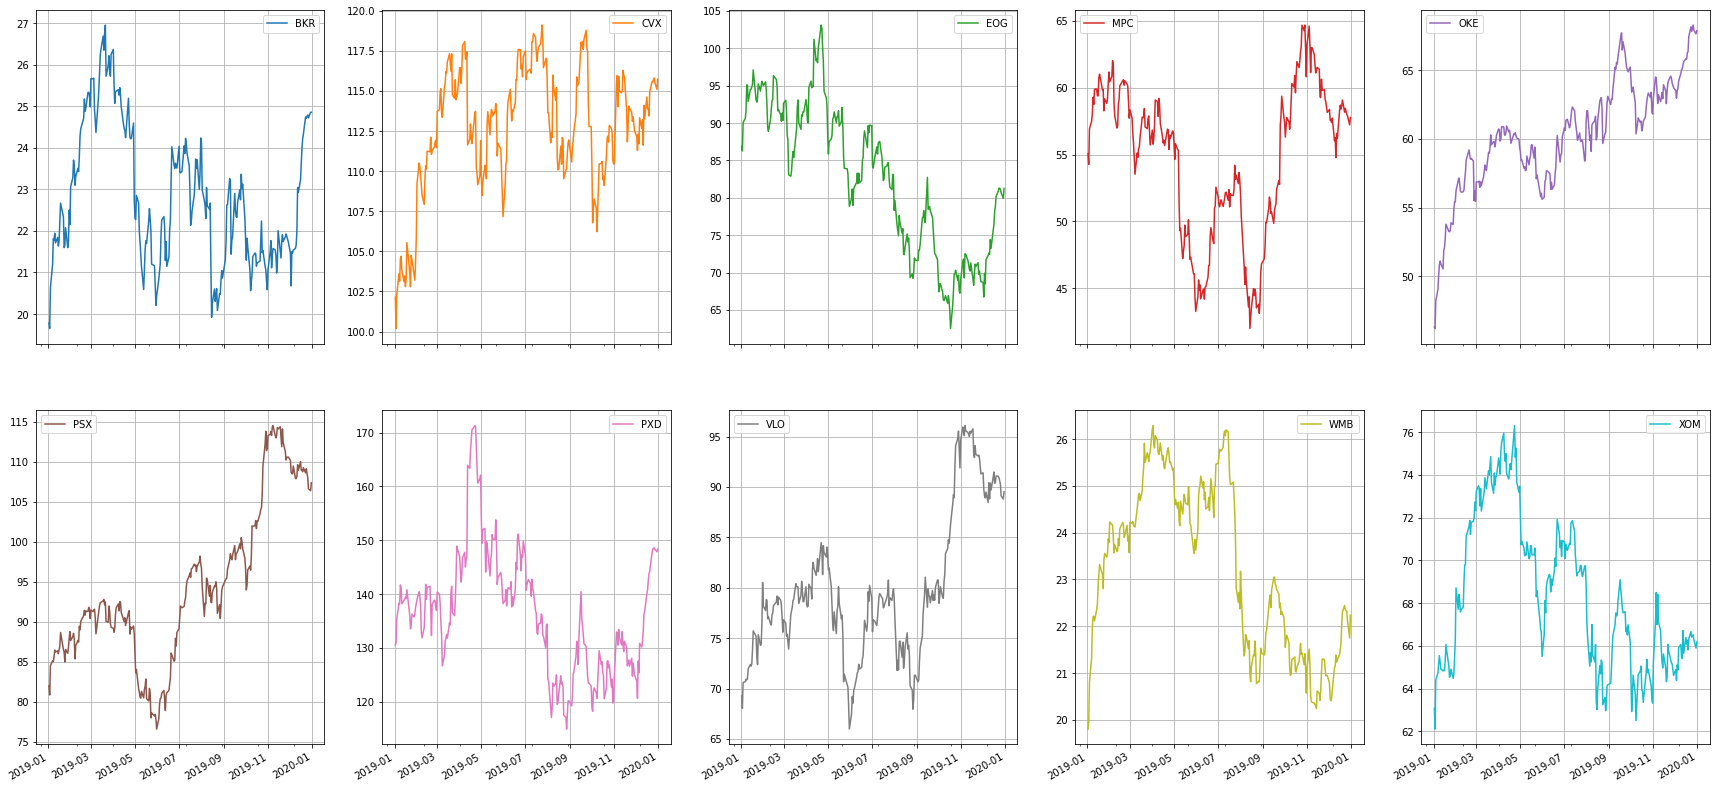

In [108]:
# Plot the time series of the daily price
prep_data.plot(subplots=True,grid=True,layout=(2,5), figsize=(30,15))
plt.show()

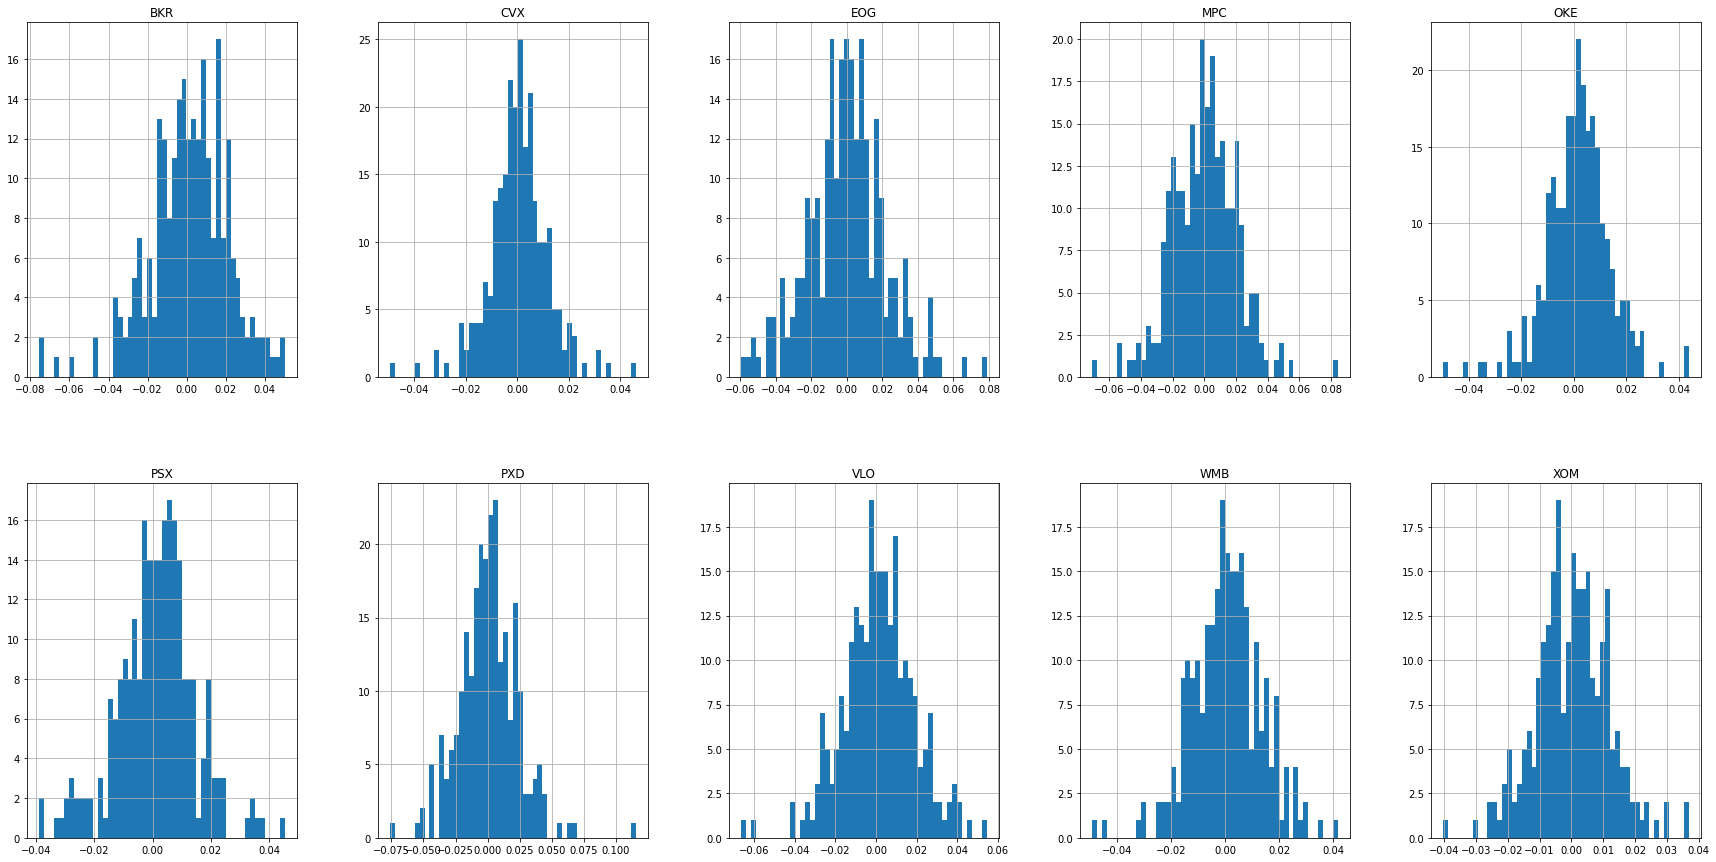

In [109]:
# Make a histogram of the return data
return_data.hist(bins=50,layout=(2,5),figsize=(30,15))
plt.show()

In [239]:
print(return_data.describe())

              BKR         CVX         EOG  ...         VLO         WMB         XOM
count  251.000000  251.000000  251.000000  ...  251.000000  251.000000  251.000000
mean     0.001118    0.000564   -0.000033  ...    0.001180    0.000546    0.000257
std      0.020344    0.011571    0.021659  ...    0.017734    0.012943    0.011500
min     -0.075487   -0.049448   -0.059405  ...   -0.066404   -0.049180   -0.040289
25%     -0.010634   -0.005483   -0.011925  ...   -0.009470   -0.007255   -0.006711
50%      0.001812    0.000738    0.000397  ...    0.001152    0.000702    0.000694
75%      0.015210    0.006648    0.011872  ...    0.011781    0.008133    0.007802
max      0.050215    0.046123    0.078725  ...    0.054515    0.041575    0.036869

[8 rows x 10 columns]


From the plots, there are many inteeresting findings:
* From the time series plot, the trend for PSX and VLO, the trend for WMB and XOM are very similar, and there might be highly correlated with each other
* From the histogram, all the distribution of ten-stock daily return appear to be normal with the mean daily returan very close to 0. 
* From the ranges of ten-stock daily return, they are all very narrow and don't expect extreme high or low daily return from the 10 stocks,
* From the two plots, the ten stock don't have a high volatilit and they are less likely to have a risk. The 10 stocks are much safer choices.

## 5. Set up the Pyomo ennvironment


In [33]:
# install pyomo
!pip install -q pyomo
from pyomo.environ import *

try:
    import google.colab
    try:
        from pyomo.environ import *
    except:
        !pip install -q pyomo
    if not 'ipopt_executable' in vars():
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
        ipopt_executable = '/content/ipopt' # THIS IS NEW! We are using the IPOPT Solver.
except:
    pass

## 6. Conduct basic caculation 

 6.1 Calulate the mean and standard deviation for the return of each  return in df. (sorted by the average daily return)


In [139]:
Return_Summary = pd.DataFrame(np.mean(return_data) ,columns=["Avg_Return"])
Return_Summary['Std_Dev_Return'] = pd.DataFrame(np.std(return_data) ,columns=["Std_Dev_Return"],index=tickers_list)
Return_Summary.sort_values(ascending=False,by="Avg_Return")

,Avg_Return,Std_Dev_Return
OKE,0.001598,0.012240
VLO,0.001180,0.017698
PSX,0.001163,0.013236
BKR,0.001118,0.020304
PXD,0.000764,0.022568
CVX,0.000564,0.011548
WMB,0.000546,0.012917
MPC,0.000397,0.020273
XOM,0.000257,0.011477
EOG,-0.000033,0.021616


The mean daily returns are very low and all are below 1%. The standard deviation are very low too and it imply we should set a very low risk ceiling.  Also it is very difficult to see the patterns between risks and return.

6.2 Calculate the convariance and correlation of each pair of two stocks.

In [111]:
# here's the covariance matrix
Covariance_matrix = return_data.cov()
Covariance_matrix

,BKR,CVX,EOG,MPC,OKE,PSX,PXD,VLO,WMB,XOM
BKR,0.000414,0.000113,0.000231,0.000200,0.000125,0.000118,0.000225,0.000131,0.000125,0.000137
CVX,0.000113,0.000134,0.000137,0.000108,0.000068,0.000081,0.000121,0.000102,0.000071,0.000100
EOG,0.000231,0.000137,0.000469,0.000197,0.000146,0.000139,0.000396,0.000166,0.000144,0.000168
MPC,0.000200,0.000108,0.000197,0.000413,0.000111,0.000178,0.000184,0.000262,0.000126,0.000132
OKE,0.000125,0.000068,0.000146,0.000111,0.000150,0.000077,0.000133,0.000106,0.000109,0.000081
PSX,0.000118,0.000081,0.000139,0.000178,0.000077,0.000176,0.000127,0.000160,0.000080,0.000092
PXD,0.000225,0.000121,0.000396,0.000184,0.000133,0.000127,0.000511,0.000168,0.000128,0.000155
VLO,0.000131,0.000102,0.000166,0.000262,0.000106,0.000160,0.000168,0.000314,0.000106,0.000116
WMB,0.000125,0.000071,0.000144,0.000126,0.000109,0.000080,0.000128,0.000106,0.000168,0.000087
XOM,0.000137,0.000100,0.000168,0.000132,0.000081,0.000092,0.000155,0.000116,0.000087,0.000132


In [112]:
# And here is the correlation matrix.
Corr_matrix = return_data.corr()
Corr_matrix

,BKR,CVX,EOG,MPC,OKE,PSX,PXD,VLO,WMB,XOM
BKR,1.000000,0.479215,0.524305,0.483533,0.499928,0.436720,0.488327,0.364477,0.473529,0.583497
CVX,0.479215,1.000000,0.547327,0.458557,0.478640,0.530943,0.460917,0.497542,0.474241,0.752075
EOG,0.524305,0.547327,1.000000,0.447432,0.549601,0.482507,0.808143,0.432997,0.512825,0.674201
MPC,0.483533,0.458557,0.447432,1.000000,0.447213,0.660866,0.400052,0.728445,0.480167,0.562941
OKE,0.499928,0.478640,0.549601,0.447213,1.000000,0.472688,0.480468,0.486003,0.687139,0.577069
PSX,0.436720,0.530943,0.482507,0.660866,0.472688,1.000000,0.422027,0.679183,0.464177,0.605194
PXD,0.488327,0.460917,0.808143,0.400052,0.480468,0.422027,1.000000,0.417882,0.436025,0.597935
VLO,0.364477,0.497542,0.432997,0.728445,0.486003,0.679183,0.417882,1.000000,0.463925,0.569796
WMB,0.473529,0.474241,0.512825,0.480167,0.687139,0.464177,0.436025,0.463925,1.000000,0.584829
XOM,0.583497,0.752075,0.674201,0.562941,0.577069,0.605194,0.597935,0.569796,0.584829,1.000000


From the result, we didn't find any stocks with negative covariance and most of stocks are slightly correlated.

## 7. Build the Nonlinear Optimization Model


7.1 Preprare for the model

In [163]:
# creating covariance table on stock return dataframe
df_cov = return_data.cov()
print('Covariance Matrix:')
print(df_cov)
print('\n') # return/blank line

# create the average of each stock
# these are the objective function COEFFICIENTS!
df_return = return_data.mean()
print('Average Return:')
print(df_return)

Covariance Matrix:
          BKR       CVX       EOG  ...       VLO       WMB       XOM
BKR  0.000414  0.000113  0.000231  ...  0.000131  0.000125  0.000137
CVX  0.000113  0.000134  0.000137  ...  0.000102  0.000071  0.000100
EOG  0.000231  0.000137  0.000469  ...  0.000166  0.000144  0.000168
MPC  0.000200  0.000108  0.000197  ...  0.000262  0.000126  0.000132
OKE  0.000125  0.000068  0.000146  ...  0.000106  0.000109  0.000081
PSX  0.000118  0.000081  0.000139  ...  0.000160  0.000080  0.000092
PXD  0.000225  0.000121  0.000396  ...  0.000168  0.000128  0.000155
VLO  0.000131  0.000102  0.000166  ...  0.000314  0.000106  0.000116
WMB  0.000125  0.000071  0.000144  ...  0.000106  0.000168  0.000087
XOM  0.000137  0.000100  0.000168  ...  0.000116  0.000087  0.000132

[10 rows x 10 columns]


Average Return:
BKR    0.001118
CVX    0.000564
EOG   -0.000033
MPC    0.000397
OKE    0.001598
PSX    0.001163
PXD    0.000764
VLO    0.001180
WMB    0.000546
XOM    0.000257
dtype: float64


7.2 First, we specify the ConcreteModel. 

In [164]:
from pyomo.environ import *
m = ConcreteModel()

# (1) defining variables
# each one is a stock (Computer, Chemical, Power, Auto, Electronic)
m.bkr = Var(within=NonNegativeReals, bounds=(0,1))
m.cvx = Var(within=NonNegativeReals, bounds=(0,1))
m.eog = Var(within=NonNegativeReals, bounds=(0,1))
m.mpc = Var(within=NonNegativeReals, bounds=(0,1))
m.oke = Var(within=NonNegativeReals, bounds=(0,1))
m.psx = Var(within=NonNegativeReals, bounds=(0,1))
m.pxd = Var(within=NonNegativeReals, bounds=(0,1))
m.vlo = Var(within=NonNegativeReals, bounds=(0,1))
m.wmb = Var(within=NonNegativeReals, bounds=(0,1))
m.xom = Var(within=NonNegativeReals, bounds=(0,1))

# (2)declare objective function by sum of the proportion of the stock times the average return for each stock
m.objective = Objective(expr =   m.bkr *df_return[0] + m.cvx*df_return[1] + m.eog*df_return[2] + 
                      m.mpc*df_return[3] + m.oke*df_return[4] +  m.psx*df_return[5] +
                       m.pxd*df_return[6] +  m.vlo*df_return[7]+  m.wmb*df_return[8] + m.xom*df_return[9],
                        sense=maximize) # yes, we want to MAX our returns!

Then, we also specify three constriants. 

1.   The sum of the proportion in our portfolio needs to be '1' or 100%.
2.   We set our return floor and our returns need to be greater than 0.0001 becasue our mean return for the stocks are very low.
3. Risk Ceiling: From the previous analysis, we know that we need a very low risk ceiling. After many attempts to run the model, max risk should be less than 0.00016 because after that all allocation of ten stocks will go to only one stock and the allocation of ten stocks keep the same before 0.0009. Thus, we set our risk level from 0.0009 to 0.00016 with tiny 0.000001. We would have 71 different risk levels

In [165]:
# declare constraints
# 1. Sum of all porportions = 1
m.sum_proportions = Constraint(expr = m.bkr+m.cvx+m.eog+m.mpc+m.oke+m.psx+m.pxd+m.vlo+m.wmb+m.xom == 1)

# 2. Minimum return should be 0.0001 or 0.01%
m.return_floor = Constraint(expr = m.objective >= 0.0001)

In [167]:
# creating calculations table for calculate the risk
# 3. Max risk should be less than 0.00016
max_risk = 0.00016
def calc_risk():
  # this is a list of all of your investment allocations (proportion invested in each stock)
  # this is UPDATED as the model is cranking - see how we are referncing the decision variables?
  proportions = [m.bkr,m.cvx,m.eog,m.mpc,m.oke,m.psx,m.pxd,m.vlo,m.wmb,m.xom]
  risk_matrix = [] # an empty list
  
  # now we iterate across the covariance matrix
  # 'risk elements' are = cov(A,B)*prop(A)*prop(B)
  # since there are 10 stocks, there are 10*10 = 100 elements
  # sum these 100 elements up at the end! that's the risk.
  for index, col in enumerate(df_cov.columns):
    i = 0
    risk = []
    for row in df_cov[col]:
      risk.append(proportions[index]*row*proportions[i])
      i = i + 1
    risk_matrix.append(risk)
  risk_matrix = pd.DataFrame(risk_matrix)
  return risk_matrix.sum().sum() 

# defining risk limits. This is what psioptparam() does.
# risk_limits is between  0.00009 and 0.00016

risk_limits = np.arange(0.00009, 0.00016, 0.000001) # take tiny steps
risk_limits

array([9.00e-05, 9.10e-05, 9.20e-05, 9.30e-05, 9.40e-05, 9.50e-05,
       9.60e-05, 9.70e-05, 9.80e-05, 9.90e-05, 1.00e-04, 1.01e-04,
       1.02e-04, 1.03e-04, 1.04e-04, 1.05e-04, 1.06e-04, 1.07e-04,
       1.08e-04, 1.09e-04, 1.10e-04, 1.11e-04, 1.12e-04, 1.13e-04,
       1.14e-04, 1.15e-04, 1.16e-04, 1.17e-04, 1.18e-04, 1.19e-04,
       1.20e-04, 1.21e-04, 1.22e-04, 1.23e-04, 1.24e-04, 1.25e-04,
       1.26e-04, 1.27e-04, 1.28e-04, 1.29e-04, 1.30e-04, 1.31e-04,
       1.32e-04, 1.33e-04, 1.34e-04, 1.35e-04, 1.36e-04, 1.37e-04,
       1.38e-04, 1.39e-04, 1.40e-04, 1.41e-04, 1.42e-04, 1.43e-04,
       1.44e-04, 1.45e-04, 1.46e-04, 1.47e-04, 1.48e-04, 1.49e-04,
       1.50e-04, 1.51e-04, 1.52e-04, 1.53e-04, 1.54e-04, 1.55e-04,
       1.56e-04, 1.57e-04, 1.58e-04, 1.59e-04, 1.60e-04])

## 8. Run the models and get the solutions
Basked on the risk levels, we have 71 models and thus 71 solutions

In [213]:
# updating risk contraint for each limit and then solving the problem
param_analysis = {} # key=risk, value =stock allocations 
returns = {} # key=risk, value = return
for r in risk_limits:
  m.total_risk = Constraint(expr = calc_risk() <= r)
  # run solver
  result = SolverFactory('ipopt', executable=ipopt_executable).solve(m).write()
  # store our allocation proportions

  param_analysis[r] = [m.bkr(),m.cvx(),m.eog(),m.mpc(),m.oke(),m.psx(),m.pxd(),m.vlo(),m.wmb(),m.xom()]
  # store our returns
  returns[r] = m.bkr()*df_return[0] + m.cvx()*df_return[1] + m.eog()*df_return[2] + m.mpc()*df_return[3] + m.oke()*df_return[4] +  m.psx()*df_return[5] + m.pxd()*df_return[6] +  m.vlo()*df_return[7]+  m.wmb()*df_return[8] + m.xom()*df_return[9]

    'pyomo.core.base.constraint.SimpleConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.AbstractSimpleConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    model=unknown;
        message from solver=Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 10
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information


## 9. Parameter Analysis
Let's see what the efficient frontier looks like, and the allocations at different risk levels

9.1 Visulize the portifio allocations of 10 stocks at 71 different risk levels.

In [214]:
# generating the dataframe for proportions of the portfolio for each risk limit
pd.set_option('display.max_rows', None)
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.columns = tickers_list
param_analysis = param_analysis.assign(risk = risk_limits)
param_analysis

,BKR,CVX,EOG,MPC,OKE,PSX,PXD,VLO,WMB,XOM,risk
0.000090,4.116944e-08,3.338639e-01,1.626104e-08,3.350246e-08,0.243054,0.160506,2.752305e-08,5.976478e-08,1.341913e-01,1.283849e-01,0.000090
0.000091,4.116941e-08,3.338640e-01,1.626104e-08,3.350249e-08,0.243053,0.160506,2.752303e-08,5.976478e-08,1.341915e-01,1.283849e-01,0.000091
0.000092,0.000000e+00,3.338640e-01,0.000000e+00,0.000000e+00,0.243054,0.160506,0.000000e+00,0.000000e+00,1.341913e-01,1.283849e-01,0.000092
0.000093,8.562973e-09,3.338640e-01,0.000000e+00,5.781575e-09,0.243054,0.160506,3.612389e-09,1.530896e-08,1.341913e-01,1.283849e-01,0.000093
0.000094,8.563173e-09,3.338639e-01,0.000000e+00,5.781753e-09,0.243054,0.160506,3.612561e-09,1.530915e-08,1.341913e-01,1.283850e-01,0.000094
0.000095,2.510757e-08,3.338640e-01,4.729048e-09,1.908546e-08,0.243054,0.160506,1.433101e-08,4.079271e-08,1.341913e-01,1.283849e-01,0.000095
0.000096,0.000000e+00,3.338640e-01,0.000000e+00,0.000000e+00,0.243054,0.160506,0.000000e+00,0.000000e+00,1.341913e-01,1.283849e-01,0.000096
0.000097,4.330260e-07,3.371385e-01,1.908300e-07,3.188307e-07,0.299001,0.180979,2.979983e-07,5.732348e-07,1.052269e-01,7.765329e-02,0.000097
0.000098,9.353209e-07,3.403160e-01,3.684446e-07,6.033742e-07,0.353380,0.200877,6.106389e-07,1.187792e-06,7.707244e-02,2.835149e-02,0.000098
0.000099,1.320970e-06,3.395136e-01,4.797220e-07,7.796935e-07,0.389945,0.213496,8.276726e-07,1.635076e-06,5.687347e-02,1.677771e-04,0.000099


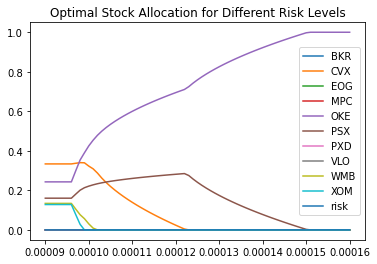

In [198]:
# plot the allocation at different risk levels
param_analysis.plot()
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.show()

On the lefthand side, we have low risk and high diversity.

On the righthand side, we have high risk and low diversity (we dump all of our money in the Auto stocks!)

9.2 Plot the efficient frontier - risk (X) vs. return (Y)!

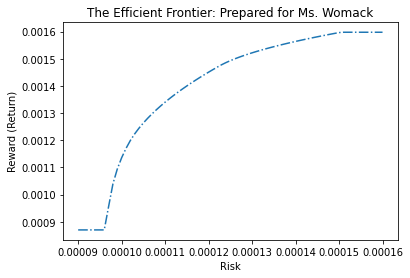

In [200]:
# plot! pylab makes it easy
reward = list(returns.values())
from pylab import *
plot(risk_limits, reward, '-.')
title('The Efficient Frontier: Prepared for Ms. Womack')
xlabel('Risk')
ylabel('Reward (Return)')
plt.show()

To prepare for the next section, we would select the allocation at the risk level = 0.000091

In [238]:
# sort all the solutions by the WMB value
param_analysis.sort_values(by='WMB',ascending=False).head()

,BKR,CVX,EOG,MPC,OKE,PSX,PXD,VLO,WMB,XOM,risk
0.000091,4.116941e-08,0.333864,1.626104e-08,3.350249e-08,0.243053,0.160506,2.752303e-08,5.976478e-08,0.134192,0.128385,0.000091
0.000090,4.116944e-08,0.333864,1.626104e-08,3.350246e-08,0.243054,0.160506,2.752305e-08,5.976478e-08,0.134191,0.128385,0.000090
0.000093,8.562973e-09,0.333864,0.000000e+00,5.781575e-09,0.243054,0.160506,3.612389e-09,1.530896e-08,0.134191,0.128385,0.000093
0.000096,0.000000e+00,0.333864,0.000000e+00,0.000000e+00,0.243054,0.160506,0.000000e+00,0.000000e+00,0.134191,0.128385,0.000096
0.000092,0.000000e+00,0.333864,0.000000e+00,0.000000e+00,0.243054,0.160506,0.000000e+00,0.000000e+00,0.134191,0.128385,0.000092


The reason can be found in next notebook. Only WMB didn't declined  based on the stock trends in 2020, and to lose less money, we have to choose the allocation with the highest proportion of  the WMB.  